In [1]:
import torchdata.datapipes as dp
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import numpy as np
import ot
import matplotlib.pyplot as plt



In [2]:
device = torch.device('cpu')

noise_size = 62

# Number of training epochs
num_epochs = 6

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

ngpu = 0

weight_cliping_limit = 0.01

batch_size = 1024

test_batch_size = 65536

w_dim = 5

data_dim = int(w_dim*(w_dim - 1)//2)

In [3]:
def row_processer(row):
    return np.array(row, dtype= np.float32)

filename = f"samples/samples_{w_dim}-dim.csv"
datapipe = dp.iter.FileOpener([filename], mode='b')
datapipe = datapipe.parse_csv(delimiter=',')
datapipe = datapipe.map(row_processer)

In [4]:
dataloader = DataLoader(dataset=datapipe, batch_size=batch_size, num_workers=2)

In [5]:
d = next(iter(dataloader))
print(d)
print(d.shape)
if d.size(1) != data_dim + w_dim:
    print("!!!!!!!!!!!!!!!!!!!!!!!!! WRONG DATA DIMENSIONS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

tensor([[ 9.1455e-01,  6.7208e-01, -1.2374e+00,  ..., -2.3534e-02,
         -7.0288e-03, -2.8679e-02],
        [ 1.0073e+00,  3.4495e-01, -5.6485e-01,  ...,  1.0543e-02,
          2.2330e-03, -2.3029e-02],
        [-1.7327e+00, -1.5207e+00, -1.1753e+00,  ...,  1.3987e-02,
          1.8203e-02,  6.4103e-03],
        ...,
        [ 8.3421e-01,  1.0176e+00,  1.1320e-01,  ...,  1.4090e-04,
          1.2732e-03, -1.8352e-03],
        [ 9.3480e-01, -8.9103e-01,  5.3051e-03,  ..., -1.1387e-03,
         -9.4065e-04, -1.3659e-03],
        [ 4.6579e-01,  1.1129e+00,  4.4970e-02,  ...,  7.8472e-04,
         -1.4968e-03, -1.3260e-03]])
torch.Size([1024, 15])


In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(w_dim+noise_size,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128,data_dim)
        )

    def forward(self, input):
        return self.main(input)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(w_dim + data_dim,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),

            nn.Linear(512,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),

            nn.Linear(512,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),

            nn.Linear(128,1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
netD = Discriminator().to(device)
netD.apply(weights_init)
netG = Generator().to(device)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): Linear(in_features=67, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [10]:
optG = torch.optim.Adam(netG.parameters(),lr = lr, betas=(beta1,0.999))
optD = torch.optim.Adam(netD.parameters(), lr = lr, betas=(beta1,0.999))

W_fixed: torch.Tensor = torch.tensor([1.0,-0.5,-1.2,-0.3,0.7,0.2,-0.9,0.1,1.7])
W_fixed = W_fixed[:w_dim].unsqueeze(1).transpose(1,0)
W_fixed = W_fixed.expand((test_batch_size,w_dim))

test_filename = f"samples/fixed_samples_{w_dim}-dim.csv"
A_fixed_true = np.genfromtxt(test_filename,dtype=float,delimiter=',',)
A_fixed_true = A_fixed_true[:,w_dim:(w_dim+data_dim)]

wass_errors = []

iters = 0

one = torch.FloatTensor([1])
mone = one * -1

In [11]:
for epoch in range(num_epochs):

    for i, data in enumerate(dataloader):
        netD.zero_grad()

        for p in netD.parameters():
            p.data.clamp_(-weight_cliping_limit, weight_cliping_limit)


        b_size = data.size(0)

        out_D_real = netD(data)
        lossDr = out_D_real.mean(0).view(1)
        lossDr.backward(one)

        W = data[:,:w_dim]
        A_real = data[:,w_dim:(w_dim + data_dim)]
        noise = torch.randn((b_size,noise_size), dtype=torch.float, device=device)
        gen_in = torch.cat((noise,W),1)
        generated_A = netG(gen_in)
        fake_in = torch.cat((W,generated_A.detach()),1)

        lossDf = netD(fake_in)
        lossDf = lossDf.mean(0).view(1)
        lossDf.backward(mone)
        lossD = lossDr - lossDf
        optD.step()

        if i%10==0:
            netG.zero_grad()

            fake_in = torch.cat((W,generated_A),1)
            lossG = netD(fake_in)
            lossG = lossG.mean(0).view(1)
            lossG.backward(one)
            optG.step()

        if iters%100 == 0:

            noise = torch.randn((test_batch_size,noise_size), dtype=torch.float, device=device)
            g_in = torch.cat((noise,W_fixed),1)
            A_fixed_gen = netG(g_in).detach().numpy()
            errors = [ot.wasserstein_1d(A_fixed_true[:,i],A_fixed_gen[:,i],p=2) for i in range(data_dim)]
            pretty_errors = ["{0:0.4f}".format(i) for i in errors]
            print(f"epoch: {epoch}/{num_epochs}, iter: {iters},\n errors: {pretty_errors}")
            wass_errors.append(errors)

        iters += 1

epoch: 0/6, iter: 0,
 errors: ['0.1235', '0.1695', '0.1577', '0.1709', '0.1012', '0.1801', '0.4842', '0.1575', '0.1406', '0.1745']
epoch: 0/6, iter: 100,
 errors: ['0.0873', '0.1310', '0.1321', '0.1293', '0.0704', '0.1380', '0.4281', '0.1247', '0.1041', '0.1296']
epoch: 0/6, iter: 200,
 errors: ['0.0860', '0.1256', '0.1395', '0.1314', '0.0734', '0.1450', '0.4234', '0.1208', '0.1030', '0.1362']
epoch: 0/6, iter: 300,
 errors: ['0.1060', '0.1372', '0.1506', '0.1346', '0.0803', '0.1544', '0.4271', '0.1296', '0.1051', '0.1864']
epoch: 0/6, iter: 400,
 errors: ['0.1068', '0.1589', '0.1646', '0.1273', '0.0971', '0.1611', '0.4232', '0.1225', '0.1015', '0.2163']
epoch: 0/6, iter: 500,
 errors: ['0.1055', '0.1747', '0.1671', '0.1266', '0.1094', '0.1572', '0.4291', '0.1214', '0.1080', '0.2148']
epoch: 0/6, iter: 600,
 errors: ['0.1092', '0.1841', '0.1711', '0.1308', '0.1271', '0.1560', '0.4402', '0.1262', '0.1140', '0.2071']
epoch: 0/6, iter: 700,
 errors: ['0.1059', '0.1852', '0.1799', '0.1376'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


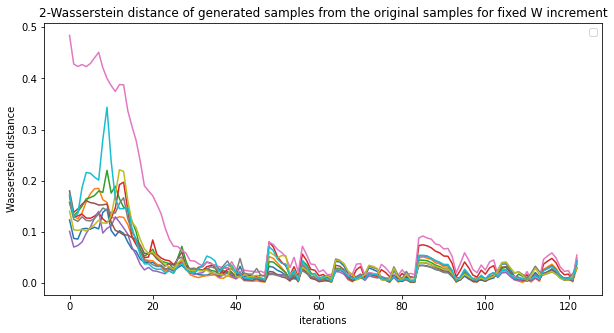

In [12]:
plt.figure(figsize=(10,5))
plt.title("2-Wasserstein distance of generated samples from the original samples for fixed W increment")
plt.plot(wass_errors)
plt.xlabel("iterations")
plt.ylabel("Wasserstein distance")
plt.legend()
plt.show()

In [15]:


for i in range(data_dim):
    true_col = A_fixed_true[:,i]
    generated_col = A_fixed_gen[:,i]
    dist = ot.wasserstein_1d(true_col,generated_col,p=2)
    print(dist)

0.02739226736530124
0.028295709151979195
0.047952714300067555
0.04085931943229795
0.04231588662638354
0.036230958221288995
0.05351002444724435
0.03030628998118454
0.0286379082773687
0.040540167692470944
